In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  '/content/drive/MyDrive/ROB498/data.zip' -d '/content'

Archive:  /content/drive/MyDrive/ROB498/data.zip
  inflating: /content/data/point_cloud_Y.txt  
  inflating: /content/data/cls/train_data.npy  
  inflating: /content/data/point_cloud_X.txt  
  inflating: /content/data/seg/.DS_Store  
  inflating: /content/data/cls/.DS_Store  
   creating: /content/data/cls/.ipynb_checkpoints/
   creating: /content/data/seg/.ipynb_checkpoints/
  inflating: /content/data/cls/test_labels.npy  
  inflating: /content/data/seg/train_labels.npy  
  inflating: /content/data/cls/train_labels.npy  
  inflating: /content/data/seg/test_labels.npy  
  inflating: /content/data/cls/test_data.npy  
  inflating: /content/data/seg/test_data.npy  
  inflating: /content/data/generate_point_cloud.npz  
  inflating: /content/data/seg/train_data.npy  


# DataLoader

In [ ]:
class cocoDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        if train:
            self.data_path = self.path + "/train_data.npy"
            self.label_path = self.path + "/train_labels.npy"
        else:
            self.data_path = self.path + "/test_data.npy"
            self.label_path = self.path + "/test_labels.npy"
        self.data = torch.from_numpy(np.load(self.data_path))[:,0:1024,:]
        self.label = torch.from_numpy(np.load(self.label_path)).to(torch.long)[:,0:1024]
    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def get_data_loader(path, batch_size, train=True):
    """
    Creates training and test data loaders
    """
    dataset = cocoDataset(path, train)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, num_workers=1)


    return dataloader

# Util

In [ ]:
def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc


def farthest_point_sample(xyz,npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = torch.device('cuda')#xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        distance = torch.min(distance, dist)
        farthest = torch.max(distance, -1)[1]
    return centroids


def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.
    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]

    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def knn_point(k, xyz, new_xyz):
    """
    K nearest neighborhood.

    Input:
        k: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]

    Output:
        group_idx: grouped points index, [B, S, k]
    """
    sqrdists = square_distance(new_xyz, xyz)
    _, group_idx = torch.topk(sqrdists, k, dim=-1, largest=False, sorted=False)
    return group_idx

def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]

    Output:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def sample_knn_group(s, k, coords, features):
    """
    Sampling by FPS and grouping by KNN.

    Input:
        s[int]: number of points to be sampled by FPS
        k[int]: number of points to be grouped into a neighbor by KNN
        coords[tensor]: input points coordinates data with size of [B, N, 3]
        features[tensor]: input points features data with size of [B, N, D]

    Returns:
        new_coords[tensor]: sampled and grouped points coordinates by FPS with size of [B, s, k, 3]
        new_features[tensor]: sampled and grouped points features by FPS with size of [B, s, k, 2D]
    """
    batch_size = coords.shape[0]
    coords = coords.contiguous()

    # FPS sampling
    fps_idx = farthest_point_sample(coords, s).long()  # [B, s]
    new_coords = index_points(coords, fps_idx)                         # [B, s, 3]
    new_features = index_points(features, fps_idx)                     # [B, s, D]

    # K-nn grouping
    idx = knn_point(k, coords, new_coords)                                             # [B, s, k]
    grouped_features = index_points(features, idx)                                      # [B, s, k, D]

    # Matrix sub
    grouped_features_norm = grouped_features - new_features.view(batch_size, s, 1, -1)  # [B, s, k, D]

    # Concat
    aggregated_features = torch.cat([grouped_features_norm, new_features.view(batch_size, s, 1, -1).repeat(1, 1, k, 1)], dim=-1)  # [B, s, k, 2D]
    return new_coords, aggregated_features

class SelfAttention(nn.Module):
    def __init__(self,in_channel):
        super(SelfAttention,self).__init__()
        self.in_channel = in_channel
        self.q_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.v_conv = nn.Conv1d(in_channel, in_channel, 1)

        self.q_conv.weight = self.k_conv.weight
        self.trans_conv = nn.Conv1d(in_channel, in_channel, 1)
        self.after_norm = nn.BatchNorm1d(in_channel)
        self.activate = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self,x):
        x_q = self.q_conv(x).permute(0, 2, 1)
        x_k = self.k_conv(x)
        x_v = self.v_conv(x)

        div = math.sqrt(self.in_channel // 4)
        energy = torch.bmm(x_q, x_k) / div

        attention = self.softmax(energy)

        x_s = torch.bmm(x_v, attention)
        x_s = self.activate(self.after_norm(self.trans_conv(x_s)))

        x = x + x_s
        return x

class OffSetAttention(nn.Module):
    def __init__(self,in_channel):
        super(OffSetAttention,self).__init__()
        self.in_channel = in_channel
        self.q_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.v_conv = nn.Conv1d(in_channel, in_channel, 1)

        self.q_conv.weight = self.k_conv.weight
        self.trans_conv = nn.Conv1d(in_channel, in_channel, 1)
        self.after_norm = nn.BatchNorm1d(in_channel)
        self.activate = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x):
        x_q = self.q_conv(x).permute(0, 2, 1)
        x_k = self.k_conv(x)
        x_v = self.v_conv(x)

        energy = torch.bmm(x_q, x_k)
        attention_raw = self.softmax(energy)

        sum_atten_raw = 1e-9 + attention_raw.sum(dim=1, keepdims=True)
        attention = attention_raw / sum_atten_raw

        x_a = torch.bmm(x_v, attention)
        x_d = x - x_a
        x_r = self.activate(self.after_norm(self.trans_conv(x_d)))
        x = x + x_r

        return x

class SampleGroup(nn.Module):
    def __init__(self,s,k,in_channel,out_channel):
        super(SampleGroup,self).__init__()
        self.s = s
        self.k = k
        self.conv1 = nn.Conv1d(in_channel, out_channel, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channel, out_channel, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.bn2 = nn.BatchNorm1d(out_channel)

    def forward(self,x,coordinates):
        x = x.permute(0, 2, 1)
        new_xyz, new_feature = sample_knn_group(self.s, self.k, coordinates, x)
        b, s, k, d = new_feature.size()
        new_feature = new_feature.permute(0, 1, 3, 2).reshape(-1, d, k)
        batch_size = new_feature.size(0)
        new_feature = F.relu(self.bn1(self.conv1(new_feature)))
        new_feature = F.relu(self.bn2(self.conv2(new_feature)))
        new_feature = F.adaptive_max_pool1d(new_feature, 1).view(batch_size, -1)
        new_feature = new_feature.reshape(b, s, -1).permute(0, 2, 1)
        return new_xyz, new_feature

class Embedding(nn.Module):
    def __init__(self,in_channel):
        super(Embedding,self).__init__()
        self.lbr0 = nn.Sequential(
                    nn.Conv1d(in_channels=in_channel,out_channels=128,kernel_size=1),
                    nn.BatchNorm1d(128),
                    nn.ReLU()
                )

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=128,out_channels=128,kernel_size=1),
                    nn.BatchNorm1d(128),
                    nn.ReLU()
                )

    def forward(self,x):
        x1 = self.lbr0(x)
        x2 = self.lbr1(x1)
        return x2

class NeighborEmbedding(nn.Module):
    def __init__(self,in_channel):
        super(NeighborEmbedding, self).__init__()

        self.conv1 = nn.Conv1d(in_channel, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

        self.sg1 = SampleGroup(s=512,k=32,in_channel=128, out_channel=128)
        self.sg2 = SampleGroup(s=256,k=32,in_channel=256, out_channel=256)

    def forward(self, x):
        """
        Input:
            x: [B, 6, N]
        """
        xyz = x.permute(0, 2, 1)[:,:,0:3]  # [B, N ,3]

        features = F.relu(self.bn1(self.conv1(x)))        # [B, 64, N]
        features = F.relu(self.bn2(self.conv2(features))) # [B, 64, N]

        xyz1, features1 = self.sg1(features, xyz)         # [B, 128, 512]
        _, features2 = self.sg2(features1, xyz1)
        return features2

def train(train_dataloader,model,opt,epoch,device,task):
    model.train()
    step = epoch*len(train_dataloader)
    epoch_loss = 0
    classes = 6
    for i,batch in enumerate(train_dataloader):
        point_clouds,labels = batch
        point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()
        labels = labels.view(-1).to(device).to(torch.long)
        if task=='classification':
          output = model(point_clouds)
        else:
          output = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])

        #output = model.forward(point_clouds,labels)
        #print(output.shape)
        #print(labels.shape)
        opt.zero_grad()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, labels)
        # print(t, loss.item())
        loss.backward()
        opt.step()
        epoch_loss += loss

    return epoch_loss

def test(test_dataloader,model,epoch,device,task):
    model.eval()
    correct_obj = 0
    num_obj = 0
    classes = 6
    for batch in test_dataloader:
        point_clouds, labels = batch
        point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()
        #point_clouds = point_clouds.to(device)
        labels = labels.view(-1).to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        if task=='classification':
          predictions = model(point_clouds)
        else:
          predictions = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])
        predictions = torch.argmax(predictions,dim=1)
        correct_obj += torch.sum(predictions==labels).item()
        num_obj += len(labels)
        #print("num_obj num_correct",num_obj,correct_obj)
        #########################################
    # Compute Accuracy of Test Dataset
    accuracy = correct_obj / num_obj

    return accuracy

# Inference: NaivePCT

## Network

In [ ]:
class NaivePCTransSeg(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='segmentation'):
        super(NaivePCTransSeg,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = Embedding(in_channel)

        self.sa1 = SelfAttention(128)
        self.sa2 = SelfAttention(128)
        self.sa3 = SelfAttention(128)
        self.sa4 = SelfAttention(128)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbrd4 = nn.Sequential(
                    nn.Conv1d(in_channels=3136,out_channels=512,kernel_size=1),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout()
                )
        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )
        self.Conv1 = nn.Conv1d(256,self.out_channel,1)

        self.label_lbr = nn.Sequential(
                    nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    )

    def forward(self,x,labels):
        B,C,N = x.size()
        x0 = self.embed(x)
        x1 = self.sa1(x0)
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)
        x5 = torch.concatenate((x1,x2,x3,x4),1)
        x6 = self.lbr1(x5)#point feature
        #print(x6.shape)

        x_max = torch.max(x6,dim=-1)[0]
        x_mean = torch.mean(x6,dim=-1)
        x_max_features = x_max.unsqueeze(-1).repeat(1,1,N)
        x_mean_features = x_mean.unsqueeze(-1).repeat(1,1,N)
        labels_features = self.label_lbr(labels.view(B,1,N))
        x7 = torch.cat([x6,x_max_features,x_mean_features,labels_features],1)
        #print(x7.shape)
        x8 = self.lbrd4(x7)
        x9 = self.lbr2(x8)
        x10 = self.Conv1(x9)
        return x10

## Inference

In [ ]:
CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
COLOR_MAP = {
    0  : (47, 79, 79),
    1  : (139, 69, 19),
    2  : (34, 139, 34),
    3  : (75, 0, 130),
    4  : (255, 0, 0),
    5  : (255, 255, 0)}

NUM_CLASSES = 6
NUM_FEATURES = 3
NUM_TRAIN_POINTS = 1024
learning_rate = 0.001
Batch_size = 16
num_epochs = 50
model= NaivePCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,'segmentation')
model.load_state_dict(torch.load('drive/MyDrive/ROB498/model/best_segmentation_model10_NAIVE_normal.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
path = '/content/data/seg/'
train_dataloader = get_data_loader(path,Batch_size, True)
test_dataloader = get_data_loader(path,Batch_size, False)
model = model.to(device)

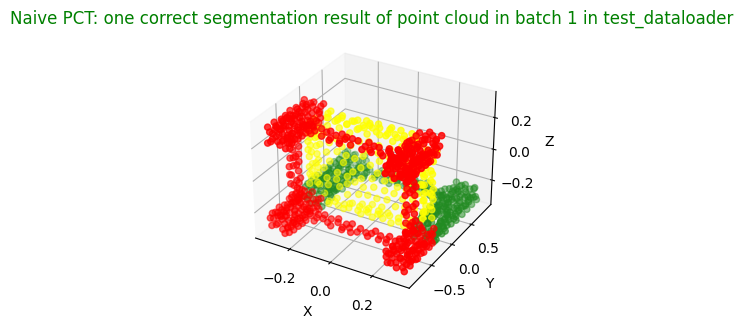

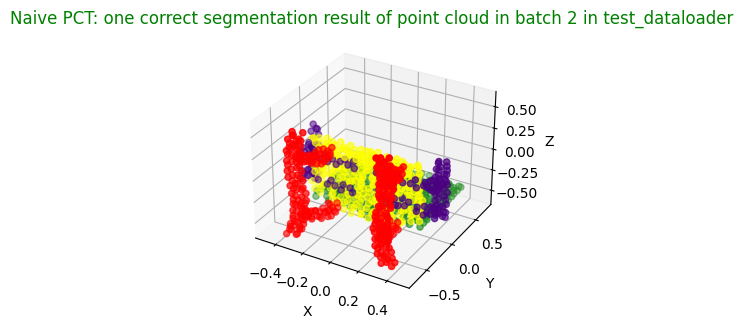

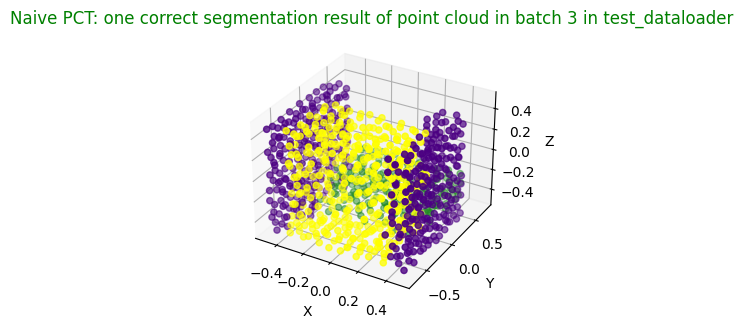

In [ ]:
model.eval()

correct_obj = 0
num_obj = 0
k = 1
classes = 6
for batch in test_dataloader:
    point_clouds, labels = batch
    B,N,C = point_clouds.size()
    point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()

    labels = labels.view(-1).to(device).to(torch.long)

    predictions = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])
    predictions = torch.argmax(predictions,dim=1).reshape([B,N])

    label_raw = labels.reshape([B,N])

    correct_idx = (predictions == label_raw).nonzero().squeeze(1)#.reshape([B,N])

    x = []
    y = []
    z = []
    colors_list = []
    #print(point_clouds.shape)
    ###visualize correct point cloud
    fig1 = plt.figure(figsize=(12, 6))
    for i, indices in enumerate([correct_idx]):
        #print(indices.shape)
        #if k==2:
        #print(i)
        #print(len(indices))
        #plot the first correct point cloud
        b_idx = indices[0][0]
        for j in range(len(indices)):
            if indices[j][0] == b_idx and len(x)<N:

            #if j >= N:
            #   break

              colors = str(label_raw[indices[j][0],indices[j][1]].cpu().numpy()+1)
              colors = COLOR_MAP[CATEGORIES[colors]]
              colors = list(np.array(colors)/255.0)
              x.append(point_clouds[indices[j][0], 0, indices[j][1]].item())
              y.append(point_clouds[indices[j][0], 1, indices[j][1]].item())
              z.append(point_clouds[indices[j][0], 2, indices[j][1]].item())
              colors_list.append(colors)
            else:
              break

    ax1 = fig1.add_subplot(1, 3, k, projection='3d')
    #if k==1:
    ax1.set_title(f"Naive PCT: one correct segmentation result of point cloud in batch {k} in test_dataloader")
      #print(len(x))
    #else:
    #  ax1.set_title("Correct points in point cloud of batch 2 in test_dataloader")
    ax1.title.set_color('green')
    ax1.scatter(x,y,z,c=[colors_list[label] for label in range(len(x))])
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    plt.show()
    k += 1
    if k==4:
      break

# Inference: OA PCT

## Network

In [ ]:
class OAPCTransSeg(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification',version='naive'):
        super(OAPCTransSeg,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = Embedding(in_channel)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = OffSetAttention(128)#SelfAttention(128)
        self.sa2 = OffSetAttention(128)#SelfAttention(128)
        self.sa3 = OffSetAttention(128)#SelfAttention(128)
        self.sa4 = OffSetAttention(128)#SelfAttention(128)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbrd4 = nn.Sequential(
                    nn.Conv1d(in_channels=3136,out_channels=512,kernel_size=1),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout()
                )
        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )
        self.Conv1 = nn.Conv1d(256,self.out_channel,1)

        self.label_lbr = nn.Sequential(
                    nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    )


    def forward(self,x,labels):
          B,C,N = x.size()
          x0 = self.embed(x)
          x1 = self.sa1(x0)
          x2 = self.sa2(x1)
          x3 = self.sa3(x2)
          x4 = self.sa4(x3)
          x5 = torch.concatenate((x1,x2,x3,x4),1)
          x6 = self.lbr1(x5)#point feature
          #print(x6.shape)

          x_max = torch.max(x6,dim=-1)[0]
          x_mean = torch.mean(x6,dim=-1)
          x_max_features = x_max.unsqueeze(-1).repeat(1,1,N)
          x_mean_features = x_mean.unsqueeze(-1).repeat(1,1,N)
          labels_features = self.label_lbr(labels.view(B,1,N))
          x7 = torch.cat([x6,x_max_features,x_mean_features,labels_features],1)
          #print(x7.shape)
          x8 = self.lbrd4(x7)
          x9 = self.lbr2(x8)
          x10 = self.Conv1(x9)
          return x10

## Inference

In [ ]:
CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
COLOR_MAP = {
    0  : (47, 79, 79),
    1  : (139, 69, 19),
    2  : (34, 139, 34),
    3  : (75, 0, 130),
    4  : (255, 0, 0),
    5  : (255, 255, 0)}

NUM_CLASSES = 6
NUM_FEATURES = 3
NUM_TRAIN_POINTS = 1024
learning_rate = 0.001
Batch_size = 16
num_epochs = 50
model= OAPCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,'segmentation')
model.load_state_dict(torch.load('drive/MyDrive/ROB498/model/best_segmentation_model10_OA_normal.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
path = '/content/data/seg/'
train_dataloader = get_data_loader(path,Batch_size, True)
test_dataloader = get_data_loader(path,Batch_size, False)
model = model.to(device)

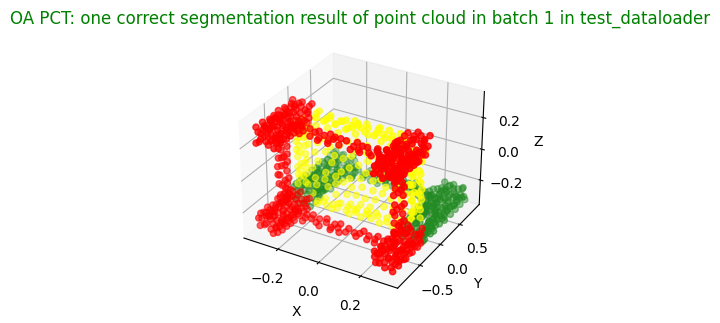

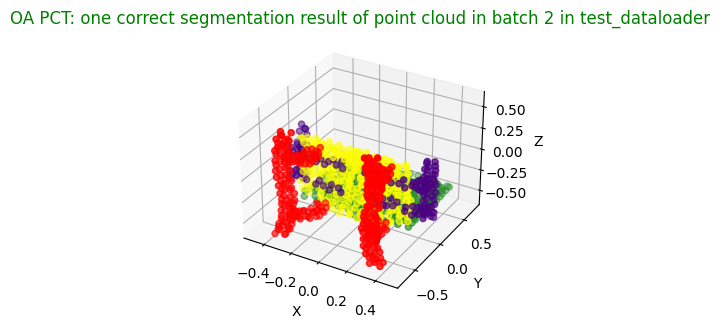

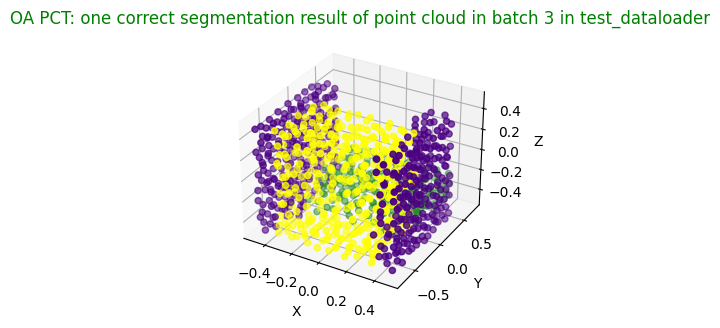

In [ ]:
model.eval()

correct_obj = 0
num_obj = 0
k = 1
classes = 6
for batch in test_dataloader:
    point_clouds, labels = batch
    B,N,C = point_clouds.size()
    point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()

    labels = labels.view(-1).to(device).to(torch.long)

    predictions = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])
    predictions = torch.argmax(predictions,dim=1).reshape([B,N])

    label_raw = labels.reshape([B,N])

    correct_idx = (predictions == label_raw).nonzero().squeeze(1)#.reshape([B,N])

    x = []
    y = []
    z = []
    colors_list = []
    #print(point_clouds.shape)
    ###visualize correct point cloud
    fig1 = plt.figure(figsize=(12, 6))
    for i, indices in enumerate([correct_idx]):
        #print(indices)
        b_idx = indices[0][0]
        for j in range(len(indices)):
            if indices[j][0] == b_idx and len(x)<N:

            #if j >= N:
            #   break

              colors = str(label_raw[indices[j][0],indices[j][1]].cpu().numpy()+1)
              colors = COLOR_MAP[CATEGORIES[colors]]
              colors = list(np.array(colors)/255.0)
              x.append(point_clouds[indices[j][0], 0, indices[j][1]].item())
              y.append(point_clouds[indices[j][0], 1, indices[j][1]].item())
              z.append(point_clouds[indices[j][0], 2, indices[j][1]].item())
              colors_list.append(colors)
            else:
              break

    ax1 = fig1.add_subplot(1, 3, k, projection='3d')
    #if k==1:
    ax1.set_title(f"OA PCT: one correct segmentation result of point cloud in batch {k} in test_dataloader")
      #print(len(x))
    #else:
    #  ax1.set_title("Correct points in point cloud of batch 2 in test_dataloader")
    ax1.title.set_color('green')
    ax1.scatter(x,y,z,c=[colors_list[label] for label in range(len(x))])
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    plt.show()
    k += 1
    if k==4:
      break

# Inference: Full PCT

## Network

In [ ]:
class FullPCTransSeg(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification',version='naive'):
        super(FullPCTransSeg,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = NeighborEmbedding(3)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = OffSetAttention(256)
        self.sa2 = OffSetAttention(256)
        self.sa3 = OffSetAttention(256)
        self.sa4 = OffSetAttention(256)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=1280,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbrd4 = nn.Sequential(
                    nn.Conv1d(in_channels=3136,out_channels=512,kernel_size=1),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout()
                )
        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )
        self.Conv1 = nn.Conv1d(256,self.out_channel,1)

        self.label_lbr = nn.Sequential(
                    nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    )


    def forward(self,x,labels):
        B,C,N = x.size()
        #print(x.size())
        x0 = self.embed(x)# batch,256,256
        x1 = self.sa1(x0)#256
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)#256
        x5 = torch.concatenate((x0,x1,x2,x3,x4),1)#1280
        x6 = self.lbr1(x5)#point feature
        #print(x6.shape)

        x_max = torch.max(x6,dim=-1)[0]
        x_mean = torch.mean(x6,dim=-1)
        x_max_features = x_max.unsqueeze(-1).repeat(1,1,N)
        x_mean_features = x_mean.unsqueeze(-1).repeat(1,1,N)
        # print("x6",x6.shape)
        # print("max",x_max_features.shape)
        # print("labels",labels.shape)
        # print("mean",x_mean_features.shape)
        labels_features = self.label_lbr(labels.view(B,1,-1))
        #print(labels_features.shape)
        x7 = torch.cat([x6.repeat(1,1,4),x_max_features,x_mean_features,labels_features],1)
        #print(x7.shape)
        #print(x7.shape)
        x8 = self.lbrd4(x7)
        x9 = self.lbr2(x8)
        x10 = self.Conv1(x9)
        return x10

## Inference

In [ ]:
CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
COLOR_MAP = {
    0  : (47, 79, 79),
    1  : (139, 69, 19),
    2  : (34, 139, 34),
    3  : (75, 0, 130),
    4  : (255, 0, 0),
    5  : (255, 255, 0)}

NUM_CLASSES = 6
NUM_FEATURES = 3
NUM_TRAIN_POINTS = 1024
learning_rate = 0.001
Batch_size = 16
num_epochs = 50
model= FullPCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,'segmentation')
model.load_state_dict(torch.load('drive/MyDrive/ROB498/model/best_segmentation_model10_Full_normal.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
path = '/content/data/seg/'
train_dataloader = get_data_loader(path,Batch_size, True)
test_dataloader = get_data_loader(path,Batch_size, False)
model = model.to(device)

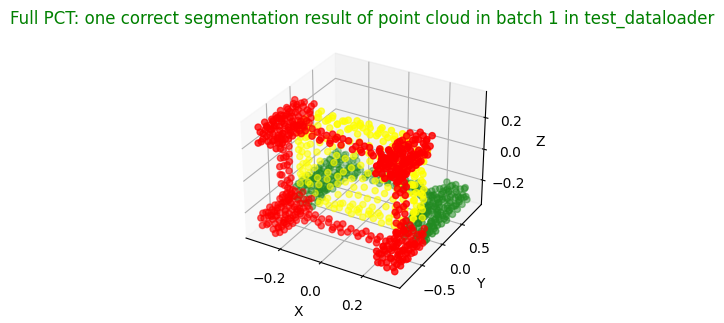

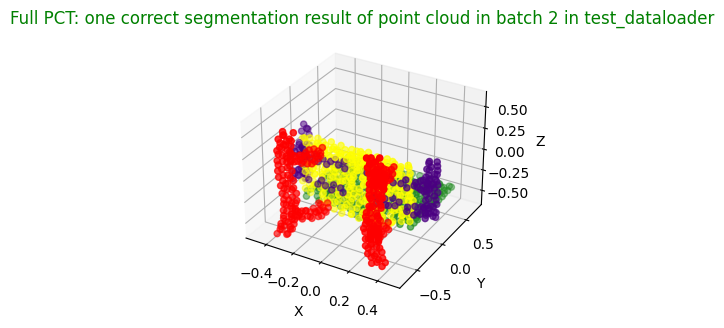

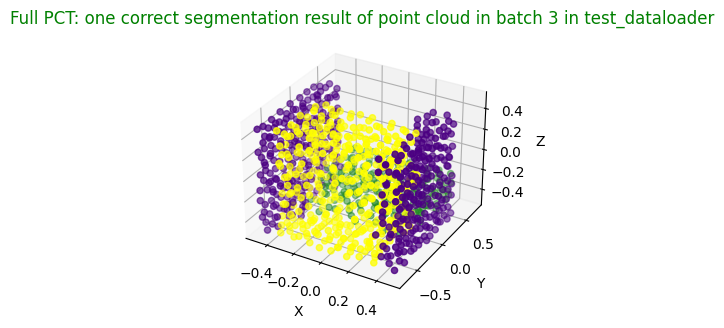

In [ ]:
model.eval()

correct_obj = 0
num_obj = 0
k = 1
classes = 6
for batch in test_dataloader:
    point_clouds, labels = batch
    B,N,C = point_clouds.size()
    point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()

    labels = labels.view(-1).to(device).to(torch.long)

    predictions = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])
    predictions = torch.argmax(predictions,dim=1).reshape([B,N])

    label_raw = labels.reshape([B,N])

    correct_idx = (predictions == label_raw).nonzero().squeeze(1)#.reshape([B,N])

    x = []
    y = []
    z = []
    colors_list = []
    #print(point_clouds.shape)
    ###visualize correct point cloud
    fig1 = plt.figure(figsize=(12, 6))
    for i, indices in enumerate([correct_idx]):
        #print(indices)
        b_idx = indices[0][0]
        for j in range(len(indices)):
            if indices[j][0] == b_idx and len(x)<N:

            #if j >= N:
            #   break

              colors = str(label_raw[indices[j][0],indices[j][1]].cpu().numpy()+1)
              colors = COLOR_MAP[CATEGORIES[colors]]
              colors = list(np.array(colors)/255.0)
              x.append(point_clouds[indices[j][0], 0, indices[j][1]].item())
              y.append(point_clouds[indices[j][0], 1, indices[j][1]].item())
              z.append(point_clouds[indices[j][0], 2, indices[j][1]].item())
              colors_list.append(colors)
            else:
              break

    ax1 = fig1.add_subplot(1, 3, k, projection='3d')
    #if k==1:
    ax1.set_title(f"Full PCT: one correct segmentation result of point cloud in batch {k} in test_dataloader")
      #print(len(x))
    #else:
    #  ax1.set_title("Correct points in point cloud of batch 2 in test_dataloader")
    ax1.title.set_color('green')
    ax1.scatter(x,y,z,c=[colors_list[label] for label in range(len(x))])
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    plt.show()
    k += 1
    if k==4:
      break